In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import random
import scipy as sp
from scipy.stats import entropy
random.seed(25)

In [ ]:
# Read the data
df = pd.read_csv("Continuous_Pathway_I_VAE_dataset1.csv")
labels = df['Product_I'].values
# Remove the first (index) and do not remove the last (label) column
df = df.drop('Unnamed: 0', axis=1)
dfcolumns = df.columns
# df = df.drop('Product_I', axis=1)
data = df.values

In [ ]:
d = data.shape[1]


mu_ml = np.mean(data,axis=0)
#print("Data mean:")
#print(mu_ml)

data_cov = np.cov(data,rowvar=False)
#print("Data cov:")
#print(data_cov)

In [ ]:
# No hidden variables < no visibles = d
q = 10

# Variance
lambdas, eigenvecs = np.linalg.eig(data_cov)
idx = lambdas.argsort()[::-1]
lambdas = lambdas[idx]
eigenvecs = - eigenvecs[:,idx]

var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])


# Weight matrix
uq = eigenvecs[:,:q]


lambdaq = np.diag(lambdas[:q])

print(uq.shape)
print(lambdaq.shape)
weight_ml = uq @ np.sqrt(lambdaq - var_ml * np.eye(q))
print(weight_ml.shape)

(20, 10)
(10, 10)
(20, 10)


In [ ]:
def sample_hidden_given_visible(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    visible_samples : np.array
    ) -> np.array:

    q = weight_ml.shape[1]
    m = np.transpose(weight_ml) @ weight_ml + var_ml * np.eye(q)

    cov = var_ml * np.linalg.inv(m) @ np.eye(q)
    act_hidden = []
    for data_visible in visible_samples:
        mean = np.linalg.inv(m) @ np.transpose(weight_ml) @ (data_visible - mu_ml)
        sample = np.random.multivariate_normal(mean,cov,size=1)
        act_hidden.append(sample[0])

    return np.array(act_hidden)

In [ ]:
act_hidden = sample_hidden_given_visible(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    visible_samples=data
    )

In [ ]:
print(act_hidden)

[[-0.40024908  0.01509864  0.7912247  ...  1.12171913 -1.06097584
  -1.1937627 ]
 [ 1.39505378 -1.85968868 -0.11435709 ... -0.48611143 -0.68690121
  -0.85359872]
 [-0.28564459  0.11013683 -0.26416495 ...  0.03889059 -2.29579251
  -1.15534642]
 ...
 [ 0.00315808 -0.14967045  0.34055021 ...  0.4206696  -0.3239336
   2.17244599]
 [ 1.01683646  0.53258922 -0.38901078 ... -1.05663793 -1.6402116
  -0.36416912]
 [ 1.02607764  0.3120334   0.49735696 ... -1.08949348 -1.71555147
  -1.00164337]]


In [ ]:
mean_hidden = np.full(q,0)
cov_hidden = np.eye(q)

no_samples = len(data)
samples_hidden = np.random.multivariate_normal(mean_hidden,cov_hidden,size=no_samples)

In [ ]:
def sample_visible_given_hidden(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    hidden_samples : np.array
    ) -> np.array:

    d = weight_ml.shape[0]

    act_visible = []
    for data_hidden in hidden_samples:
        mean = weight_ml @ data_hidden + mu_ml
        cov = var_ml * np.eye(d)
        sample = np.random.multivariate_normal(mean,cov,size=1)
        act_visible.append(sample[0])

    return np.array(act_visible)

In [ ]:
generated_samples = sample_visible_given_hidden(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    hidden_samples=samples_hidden
    )
generated_samples_df = pd.DataFrame(generated_samples, columns=dfcolumns)

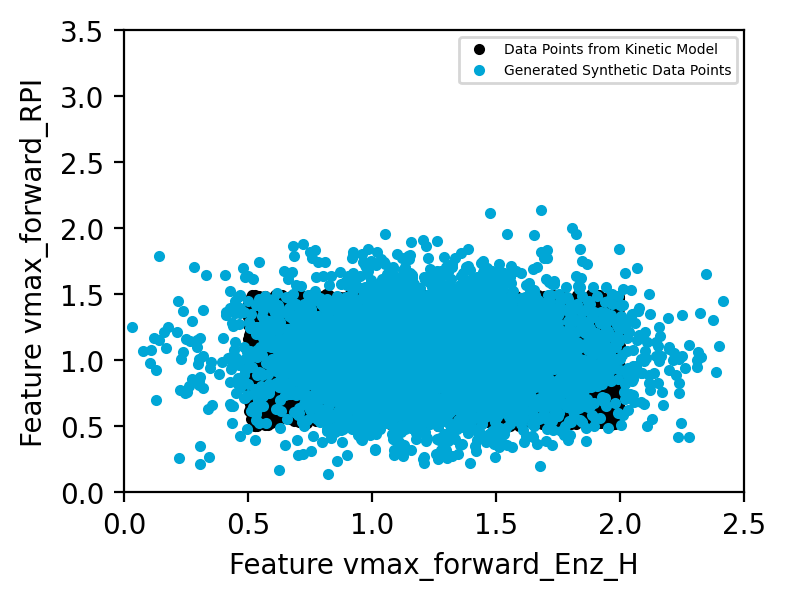

In [ ]:
feature_1 = 7
feature_2 = 10
plt.figure(figsize=(4,3))
plt.plot(data[:, feature_1], data[:, feature_2], ".", color='black')
plt.plot(generated_samples[:, feature_1], generated_samples[:, feature_2], ".", color='#00a6d6')
plt.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="5", loc ="upper right")
plt.xlabel(f"Feature {df.columns[feature_1]}")
plt.ylabel(f"Feature {df.columns[feature_2]}")
plt.axis([0, 2.5, 0, 3.5])
plt.show()

In [ ]:
pca_real = PCA(n_components=10, random_state=25)
real_result = pca_real.fit_transform(data)
pca_synthetic = PCA(n_components=10, random_state=25)
generated_samples = generated_samples_df.sample(n=2000, random_state=25)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

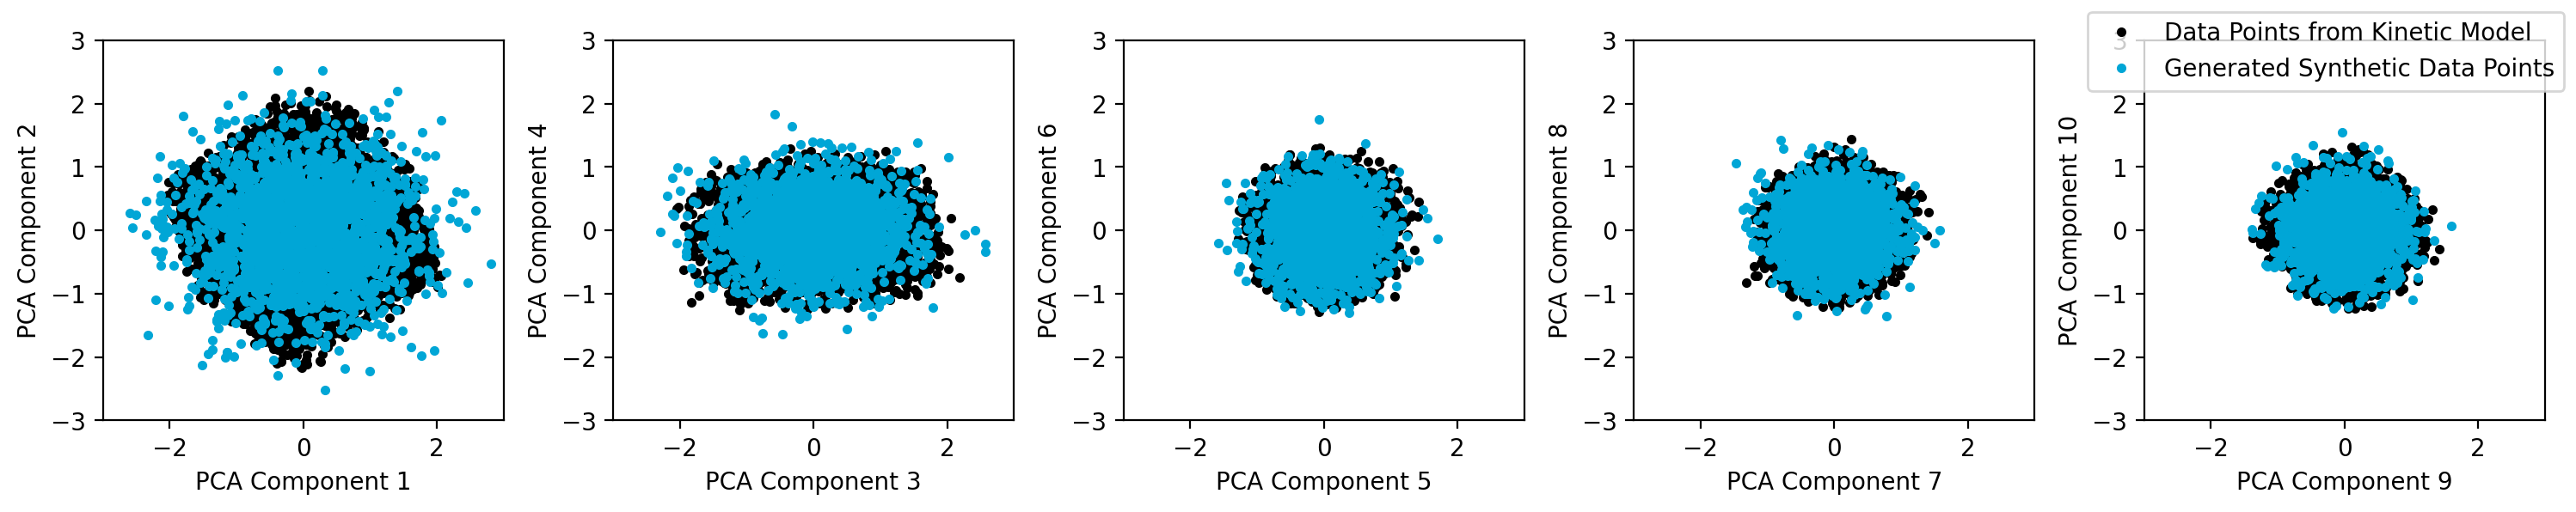

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(15,3))

for j in range(0, 10, 2):
    index = j
    index2 = j + 1
    arr_idx = j//2
    axes[arr_idx].plot(real_result[:, index], real_result[:, index2],".", color='black')
    axes[arr_idx].plot(synthetic_result[:, index], synthetic_result[:, index2],".", color='#00a6d6')
    axes[arr_idx].set_xlabel(f'PCA Component {index + 1}')
    axes[arr_idx].set_ylabel(f'PCA Component {index2 + 1}')
    axes[arr_idx].axis([-3, 3, -3, 3])
#             axes[i, j].legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="15", loc ="upper right")

fig.legend(['Data Points from Kinetic Model', 'Generated Synthetic Data Points'], fontsize="10", loc ="upper right")
fig.set_label('PCA Visualization')
plt.tight_layout(w_pad=1.0)
plt.show()

In [ ]:
# Save the data to a csv file with same column names as original
saveframe = generated_samples
saveframe.columns = dfcolumns
saveframe.to_csv("data_ppca5.csv")